In [1]:
import yfinance as yf
yf.pdr_override()
from pandas_datareader import data as pr
from bs4 import BeautifulSoup as bs
from bs4.element import Comment
import pandas as pd
import numpy as np
import requests
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import datetime as dt
import string
import time
import pickle
import seaborn as sns

In [51]:
import yfinance as yf
yf.pdr_override()
from pandas_datareader import data as pr
from bs4 import BeautifulSoup as bs
from bs4.element import Comment
import pandas as pd
import numpy as np
import requests
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import datetime as dt
from dateutil.relativedelta import relativedelta
import time
import pickle

In [125]:
def get_hyped_days(dataframe):
    if isinstance(dataframe, pd.DataFrame):
        df = dataframe.copy()
        df = df[df["Volume"] != 0]
        df['Next_day_open'] = df['Open'].shift(-1, axis = 0)
        hype_check = [df['Close'] >= df['Next_day_open']][0]
        day = 0
        while not hype_check[day]:
            day += 1
            if day == df.shape[0]:
                return np.NAN 
                break
        return day
    else:
        print('Variable is not a dataframe')
        return 0

In [3]:
def value_fix(value, replace = False):
    value = value.replace(' ','')
    value = value.split('-')[0]
    letters_pattern = str.maketrans('', '', string.ascii_letters)
    value = value.translate(letters_pattern).strip()
    if replace:
        return float(value.replace(',', '.'))
    else:
        return value.replace(',', '')

In [4]:
def value_fix_dot(value):
    value = value.replace(' ','')
    value = value.split('-')[0]
    letters_pattern = str.maketrans('', '', string.ascii_letters)
    value = value.translate(letters_pattern).strip()
    return float(value.replace('.', ''))


In [5]:
def months(month):
        Months = {
                'Ocak': '1',	
                'Şubat': '2',
                'Mart': '3',	
                'Nisan': '4',	
                'Mayıs': '5',	
                'Haziran': '6',	
                'Temmuz': '7',	
                'Ağustos': '8',	
                'Eylül': '9',	
                'Ekim': '10',	
                'Kasım': '11',	
                'Aralık': '12'
                }       
        if month in Months:
                return Months[month]
        else:
                return month
def fix_time_it(time):
        str_time = ''
        for i in time.split(' '):
                str_time += months(i) + '-'
        #return str_time[:-1]
        return dt.datetime.strptime(str(str_time[:-1]), '%d-%m-%Y').date().strftime('%Y-%m-%d')


In [6]:
def time_it(time):
    """
    Returns time data type of given string in form Y-m-d.
    Example: 2001-01-01."""
    return dt.datetime.strptime(str(time), '%Y-%m-%d')

In [7]:
def g_stocks(stock, time_delta = 999):
    time.sleep(10)
    scope =  ['https://www.googleapis.com/auth/spreadsheets', "https://www.googleapis.com/auth/drive.file", "https://www.googleapis.com/auth/drive"]
    creds = ServiceAccountCredentials.from_json_keyfile_name('cred.json', scope)
    client = gspread.authorize(creds)
    sheet = client.open('stocks').sheet1
    sheet.update_cell(1, 7, stock)
    sheet.update_cell(1, 8, time_delta)
    if not sheet.get_all_records() == []:
        df = pd.DataFrame(sheet.get_all_records())[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
        df.drop(df[df['Close'].str.len() == 0].index, inplace = True)
        type_map = {'Open': float,
                    'Close': float,
                    'High': float,
                    'Low': float,
                    'Volume':int}   
        df = df.astype(type_map)
        df['Date'] = pd.to_datetime(df['Date']).dt.strftime('%Y-%m-%d')
        return df.set_index('Date')
    else:
        return pd.DataFrame(columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume']).set_index('Date')

In [47]:
def g_stocks(stock, start, end):
    """Google finance.
    Returns historical data for given stocks for given time interval using Google Finance via using google sheets.
    Function has 10 sec time sleep, it may change, due to api limits.
    """
    try:
        scope =  ['https://www.googleapis.com/auth/spreadsheets', "https://www.googleapis.com/auth/drive.file", "https://www.googleapis.com/auth/drive"]
        creds = ServiceAccountCredentials.from_json_keyfile_name('cred.json', scope)
        client = gspread.authorize(creds)
        sheet = client.open('stocks').sheet1
        sheet.update_cell(1, 7, stock)
        sheet.update_cell(1, 9, str(start))
        sheet.update_cell(1, 10, str(end))
        if not sheet.get_all_records() == []:
            df = pd.DataFrame(sheet.get_all_records())[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
            df.drop(df[df['Close'].astype(str).str.len() == 0].index, inplace = True)
            type_map = {'Open': float,
                        'Close': float,
                        'High': float,
                        'Low': float,
                        'Volume':int}   
            df = df.astype(type_map)
            df['Date'] = pd.to_datetime(df['Date']).dt.strftime('%Y-%m-%d')
            print(f'{stock} DONE BY GOOGLE FINANCE')
            return df.set_index('Date')
        else:
            print(f'{stock} DONE BY GOOGLE FINANCE')
            return pd.DataFrame(columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume']).set_index('Date')
    except gspread.exceptions.APIError:
        print('Error 429: Too Many Requests')
        print('10sec sleep')
        time.sleep(10)
        return get_hist_data(stock = stock, start_date=start, end_date=end)

In [8]:
def page_urls(url):
    page_counter = 1
    pages = [url]
    soup = make_soup(url)
    while soup.find(class_ = 'rightNav'):
        page_counter += 1
        pages.append(url+f'page/{page_counter}/')
        soup = make_soup(pages[-1])
    return pages    


In [9]:

def make_request(url):
    """Request maker.
    Makes request for given url."""
    headers = {'User-Agent': "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/42.0.2311.135 Safari/537.36 Edge/12.246"}
    return requests.get(url=url, headers=headers)

In [10]:
def make_soup(url):
    """Soup maker.
    Returns soup for given url."""
    r = make_request(url)
    if r.status_code == 200:
        return bs(r.content, 'html5lib')
    else:
        return False

In [11]:
def get_halka_arz_info(url, soup = False):
    cols = []
    vals = []
    if not soup:
        soup = make_soup(url)
    info_table = soup.find('table', {'class': 'sp-table'})
    rows = info_table.find_all('tr')
    for row in rows:
        row_data = row.find_all('td')
        cols.append(row_data[0].text)
        vals.append(row_data[1].text)
    return pd.DataFrame(data = [vals], columns = cols)

In [41]:
def get_halka_arz_result(url, soup = False):
    if not soup:
        soup = make_soup(url)
    vals = []
    cols = []
    #cols = ['Yurtiçi_Bireysel_Kisi', 'Yurtiçi_Bireysel_Lot',
    #    'Yurtiçi_Kurumsal_Kisi', 'Yurtiçi_Kurumsal_Lot',
    #    'Yurtdışı_Kurumsal_Kisi', 'Yurtdışı_Kurumsal_Lot',
    #    'Şirket_Çalışanları_Kisi', 'Şirket_Çalışanları_Lot']
    table = soup.find('table', {'class': 'as-table'})
    if not table == None:
        rows = table.find_all('tr')
        for i in range(2, len(rows)-2):
            row_data = rows[i].find_all('td')
            for ex in ['_Kisi', '_Lot']:
                cols.append(row_data[0].text.strip()+ex)
            for j in range(1,3):
                vals.append(row_data[j].text)
        return pd.DataFrame(data = [vals], columns = cols)
    else:
        return pd.DataFrame()

In [42]:
def get_hist_data(stock, time_delta = 999):
    df = pr.DataReader(stock + '.IS')
    df.drop(columns=['Adj Close'], inplace=True)
    if df.shape[0] <= 1:
        df = g_stocks(stock, time_delta=time_delta)
    return df

In [49]:
def Delta_Time(years = 0, months = 0, weeks = 0, days = 0, start = dt.datetime.today()):
    """ Delta time function.
    Creates start and end dates. Years, months, weeks, days are set by default to 0, and start date is set to today.
    """

    start_date = start - relativedelta(years = years, months = months, weeks = weeks, days = days)
    end_date = dt.datetime.today()
    return start_date.date(), end_date.date()

In [54]:
def get_hist_data(stock, start_date, end_date):
    """"Historical Data Function.
    Returns historical data for given symbol for given time interval. Function uses Yahoo finance, 
    but in case of missing data, function uses Google finance.
    """
    df = pr.DataReader(stock + '.IS', start=start_date, end=end_date)
    df.drop(columns=['Adj Close'], inplace=True)
    if df.shape[0] <= 1:
        df = g_stocks(stock, start_date, end_date)
    return df

In [52]:
start, end = Delta_Time(years=3)

In [43]:
url = 'https://halkarz.com/k/halka-arz/'

In [44]:
start_year = dt.datetime.today().year
year_period = 3
halka_arz_pages = {}
stocks = {}
for i in range(year_period):
    year_page = url+f'{start_year - i}/'
    #halka_arz_pages.update({page : {'Pages':page_urls(page)}})
    pages = page_urls(year_page)
    for page in pages:
        page_soup = make_soup(page)
        stocks_ = page_soup.find_all(class_ = "halka-arz-list archives")
        for stock in stocks_:
            stock_content = stock.find(class_ = 'il-content')
            stock_symbol = stock_content.find(class_ = 'il-bist-kod').get_text(strip=True)
            stock_name = stock_content.find(class_ = 'il-halka-arz-sirket').find('a')['title']
            stock_page = stock_content.find(class_ = 'il-halka-arz-sirket').find('a')['href']
            stocks.update({stock_symbol :
                            {'url':stock_page,
                             'stock_name':stock_name,
                             'release_year':start_year-i}})

In [45]:
for stock in stocks:
    stocks[stock].update({'Halka_arz_info': get_halka_arz_info(stocks[stock]['url'])})
    stocks[stock].update({'Halka_arz_result': get_halka_arz_result(stocks[stock]['url'])})

In [55]:
for stock in stocks:
    print(stock)
    stocks[stock].update({'Hist_data': get_hist_data(stock, start_date=start, end_date=end)})
    

RGYAS
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['RGYAS.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



RGYAS DONE BY GOOGLE FINANCE
ENTRA
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['ENTRA.IS']: Exception("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")



ENTRA DONE BY GOOGLE FINANCE
ODINE
[*********************100%%**********************]  1 of 1 completed
MOGAN
[*********************100%%**********************]  1 of 1 completed
ARTMS
[*********************100%%**********************]  1 of 1 completed
OBAMS
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['OBAMS.IS']: Exception("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")



OBAMS DONE BY GOOGLE FINANCE
ALVES
[*********************100%%**********************]  1 of 1 completed
LMKDC
[*********************100%%**********************]  1 of 1 completed
BORSK
[*********************100%%**********************]  1 of 1 completed
PATEK
[*********************100%%**********************]  1 of 1 completed
AVPGY
[*********************100%%**********************]  1 of 1 completed
MEGMT
[*********************100%%**********************]  1 of 1 completed
KBORU
[*********************100%%**********************]  1 of 1 completed
SURGY
[*********************100%%**********************]  1 of 1 completed
CATES
[*********************100%%**********************]  1 of 1 completed
SKYMD
[*********************100%%**********************]  1 of 1 completed
BEGYO
[*********************100%%**********************]  1 of 1 completed
AGROT
[*********************100%%**********************]  1 of 1 completed
EKOS
[*********************100%%**********************]  1 of 1 comple

In [57]:

with open('stocks.p', 'wb') as handle:
    pickle.dump(stocks, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [58]:
with open('stocks.p', 'rb') as handle:
    Stocks_copy = pickle.load(handle)

In [60]:
halka_arz_info_df = pd.DataFrame()
for stock in Stocks_copy:
    halka_arz_info_df = pd.concat([halka_arz_info_df, Stocks_copy[stock]['Halka_arz_info']], axis=0, join='outer', ignore_index='True')
halka_arz_info_df.head()

,Halka Arz Tarihi :,Halka Arz Fiyatı/Aralığı :,Dağıtım Yöntemi :,Pay :,\n Aracı Kurum : \n (Konsorsiyum)\n,Bist Kodu :,Pazar :,\n Aracı Kurum : \n,Bist İlk İşlem Tarihi :,Fiili Dolaşımdaki Pay :,Fiili Dolaşımdaki Pay Oranı (%) :,Endeks :,Ek Pay :
0,\n 17-18-19 Nisan 2024\n ...,"135,00 TL",Eşit Dağıtım **,"33,357,450 Lot",Ak Yatırım Menkul Değerler A.Ş.\n ...,RGYAS,Yıldız Pazar,NaN,NaN,NaN,NaN,NaN,NaN
1,\n 27-28-29 Mart 2024\n ...,"10,00 TL",Eşit Dağıtım,"369,565,717 Lot",NaN,ENTRA,Yıldız Pazar,Ak Yatırım Menkul Değerler A.Ş.\n ...,4 Nisan 2024,NaN,NaN,NaN,NaN
2,\n 13-14-15 Mart 2024\n ...,"30,00 TL",Eşit Dağıtım,"44,200,000 Lot",NaN,ODINE,Yıldız Pazar,Türkiye Sınai Kalkınma Bankası A.Ş.\n ...,21 Mart 2024,"43,534,318 Lot",%39.39,NaN,NaN
3,\n 28-29 Şubat - 1 Mart 202...,"11,33 TL",Eşit Dağıtım,"262,635,000 Lot",NaN,MOGAN,Yıldız Pazar,İş Yatırım Menkul Değerler A.Ş.\n ...,7 Mart 2024,"262,555,096 Lot",%10.75,BIST500,NaN
4,\n 27-28 Şubat 2024\n ...,"25,35 TL",Eşit Dağıtım **,"20,000,000 Lot",NaN,ARTMS,Ana Pazar,İnfo Yatırım Menkul Değerler A.Ş.\n ...,4 Mart 2024,"19,998,335 Lot",%28.56,BIST500,NaN


In [61]:
halka_arz_info_df.drop(index=0, inplace=True)

In [62]:
halka_arz_info_df.reset_index(drop=True, inplace=True)

In [63]:
halka_arz_info_df["Bist İlk İşlem Tarihi : "] = halka_arz_info_df["Bist İlk İşlem Tarihi : "].apply(fix_time_it)

In [64]:
halka_arz_info_df

,Halka Arz Tarihi :,Halka Arz Fiyatı/Aralığı :,Dağıtım Yöntemi :,Pay :,\n Aracı Kurum : \n (Konsorsiyum)\n,Bist Kodu :,Pazar :,\n Aracı Kurum : \n,Bist İlk İşlem Tarihi :,Fiili Dolaşımdaki Pay :,Fiili Dolaşımdaki Pay Oranı (%) :,Endeks :,Ek Pay :
0,\n 27-28-29 Mart 2024\n ...,"10,00 TL",Eşit Dağıtım,"369,565,717 Lot",NaN,ENTRA,Yıldız Pazar,Ak Yatırım Menkul Değerler A.Ş.\n ...,2024-04-04,NaN,NaN,NaN,NaN
1,\n 13-14-15 Mart 2024\n ...,"30,00 TL",Eşit Dağıtım,"44,200,000 Lot",NaN,ODINE,Yıldız Pazar,Türkiye Sınai Kalkınma Bankası A.Ş.\n ...,2024-03-21,"43,534,318 Lot",%39.39,NaN,NaN
2,\n 28-29 Şubat - 1 Mart 202...,"11,33 TL",Eşit Dağıtım,"262,635,000 Lot",NaN,MOGAN,Yıldız Pazar,İş Yatırım Menkul Değerler A.Ş.\n ...,2024-03-07,"262,555,096 Lot",%10.75,BIST500,NaN
3,\n 27-28 Şubat 2024\n ...,"25,35 TL",Eşit Dağıtım **,"20,000,000 Lot",NaN,ARTMS,Ana Pazar,İnfo Yatırım Menkul Değerler A.Ş.\n ...,2024-03-04,"19,998,335 Lot",%28.56,BIST500,NaN
4,\n 22-23 Şubat 2024\n ...,"39,24 TL",Eşit Dağıtım,"96,336,345 Lot",NaN,OBAMS,Yıldız Pazar,Türkiye Kalkınma ve Yatırım Bankası A.Ş.\n ...,2024-03-01,"96,325,004 Lot",%20.09,BIST500,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,\n 22-23 Şubat 2022\n ...,"24,00 TL",Eşit Dağıtım,"37,500,000 Lot",NaN,INVES,Yıldız Pazar,Metro Yatırım Menkul Değerler A.Ş.\n ...,2022-03-01,"37,500,000 Lot",%20,BIST500,NaN
100,\n 15-16-17-18 Şubat 2022\n...,"18,50 TL",Oransal Dağıtım,"30,020,000 Lot",NaN,DAPGM,Yıldız Pazar,Garanti Yatırım Menkul Kıymetler A.Ş.\n ...,2022-02-24,"38,542,671 Lot",%10.01,BIST500,NaN
101,\n 15-16 Şubat 2022\n ...,"1,82 TL",Eşit Dağıtım,"130,000,000 Lot",NaN,HUNER,Yıldız Pazar,İnfo Yatırım Menkul Değerler A.Ş.\n ...,2022-02-21,"187,999,998 Lot","%32,41",BIST500,NaN
102,\n 9-10-11 Şubat 2022\n ...,"10,20 TL",Oransal Dağıtım,"19,250,000 Lot",NaN,PNLSN,Yıldız Pazar,Gedik Yatırım Menkul Değerler A.Ş.\n ...,2022-02-18,"20,985,116 Lot",%27.98,BIST500,"1,750,000 Lot"


In [65]:
halka_arz_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 13 columns):
 #   Column                                                                                                   Non-Null Count  Dtype 
---  ------                                                                                                   --------------  ----- 
 0   Halka Arz Tarihi :                                                                                       103 non-null    object
 1   Halka Arz Fiyatı/Aralığı :                                                                               103 non-null    object
 2   Dağıtım Yöntemi :                                                                                        103 non-null    object
 3   Pay :                                                                                                    103 non-null    object
 4   
               Aracı Kurum : 
                              (Konsorsiyum)
                 

In [66]:
halka_arz_info_df.columns

Index(['Halka Arz Tarihi : ', 'Halka Arz Fiyatı/Aralığı : ',
       'Dağıtım Yöntemi : ', 'Pay : ',
       '\n               Aracı Kurum : \n                              (Konsorsiyum)\n                            ',
       'Bist Kodu : ', 'Pazar : ',
       '\n               Aracı Kurum : \n                            ',
       'Bist İlk İşlem Tarihi : ', 'Fiili Dolaşımdaki Pay :',
       'Fiili Dolaşımdaki Pay Oranı (%) :', 'Endeks : ', 'Ek Pay : '],
      dtype='object')

In [68]:
info_df = halka_arz_info_df.drop(columns=['Halka Arz Tarihi : ',
                                        "\n               Aracı Kurum : \n                              (Konsorsiyum)\n                            ",
                                        'Endeks : ','Ek Pay : ', 'Fiili Dolaşımdaki Pay :', 'Fiili Dolaşımdaki Pay Oranı (%) :'])
info_df.head()

,Halka Arz Fiyatı/Aralığı :,Dağıtım Yöntemi :,Pay :,Bist Kodu :,Pazar :,\n Aracı Kurum : \n,Bist İlk İşlem Tarihi :
0,"10,00 TL",Eşit Dağıtım,"369,565,717 Lot",ENTRA,Yıldız Pazar,Ak Yatırım Menkul Değerler A.Ş.\n ...,2024-04-04
1,"30,00 TL",Eşit Dağıtım,"44,200,000 Lot",ODINE,Yıldız Pazar,Türkiye Sınai Kalkınma Bankası A.Ş.\n ...,2024-03-21
2,"11,33 TL",Eşit Dağıtım,"262,635,000 Lot",MOGAN,Yıldız Pazar,İş Yatırım Menkul Değerler A.Ş.\n ...,2024-03-07
3,"25,35 TL",Eşit Dağıtım **,"20,000,000 Lot",ARTMS,Ana Pazar,İnfo Yatırım Menkul Değerler A.Ş.\n ...,2024-03-04
4,"39,24 TL",Eşit Dağıtım,"96,336,345 Lot",OBAMS,Yıldız Pazar,Türkiye Kalkınma ve Yatırım Bankası A.Ş.\n ...,2024-03-01


In [69]:
info_df.rename(columns={"\n               Aracı Kurum : \n                            ": "Aracı Kurum : "}, inplace=True)

In [70]:
info_df['Halka Arz Fiyatı/Aralığı : '] = info_df['Halka Arz Fiyatı/Aralığı : '].astype(str)

In [71]:
info_df['Halka Arz Fiyatı/Aralığı : '].dropna(inplace=True)

In [72]:
info_df.drop(info_df[info_df['Halka Arz Fiyatı/Aralığı : '] == 'nan'].index, inplace=True)

In [73]:
info_df['Halka Arz Fiyatı/Aralığı : '] = info_df['Halka Arz Fiyatı/Aralığı : '].apply(value_fix, replace=True)

In [74]:
info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Halka Arz Fiyatı/Aralığı :   103 non-null    float64
 1   Dağıtım Yöntemi :            103 non-null    object 
 2   Pay :                        103 non-null    object 
 3   Bist Kodu :                  103 non-null    object 
 4   Pazar :                      103 non-null    object 
 5   Aracı Kurum :                103 non-null    object 
 6   Bist İlk İşlem Tarihi :      103 non-null    object 
dtypes: float64(1), object(6)
memory usage: 5.8+ KB


In [75]:
info_df

,Halka Arz Fiyatı/Aralığı :,Dağıtım Yöntemi :,Pay :,Bist Kodu :,Pazar :,Aracı Kurum :,Bist İlk İşlem Tarihi :
0,10.00,Eşit Dağıtım,"369,565,717 Lot",ENTRA,Yıldız Pazar,Ak Yatırım Menkul Değerler A.Ş.\n ...,2024-04-04
1,30.00,Eşit Dağıtım,"44,200,000 Lot",ODINE,Yıldız Pazar,Türkiye Sınai Kalkınma Bankası A.Ş.\n ...,2024-03-21
2,11.33,Eşit Dağıtım,"262,635,000 Lot",MOGAN,Yıldız Pazar,İş Yatırım Menkul Değerler A.Ş.\n ...,2024-03-07
3,25.35,Eşit Dağıtım **,"20,000,000 Lot",ARTMS,Ana Pazar,İnfo Yatırım Menkul Değerler A.Ş.\n ...,2024-03-04
4,39.24,Eşit Dağıtım,"96,336,345 Lot",OBAMS,Yıldız Pazar,Türkiye Kalkınma ve Yatırım Bankası A.Ş.\n ...,2024-03-01
...,...,...,...,...,...,...,...
98,11.50,Oransal Dağıtım,"35,192,308 Lot",HTTBT,Yıldız Pazar,Ünlü Menkul Değerler A.Ş.\n ...,2022-03-03
99,24.00,Eşit Dağıtım,"37,500,000 Lot",INVES,Yıldız Pazar,Metro Yatırım Menkul Değerler A.Ş.\n ...,2022-03-01
100,18.50,Oransal Dağıtım,"30,020,000 Lot",DAPGM,Yıldız Pazar,Garanti Yatırım Menkul Kıymetler A.Ş.\n ...,2022-02-24
101,1.82,Eşit Dağıtım,"130,000,000 Lot",HUNER,Yıldız Pazar,İnfo Yatırım Menkul Değerler A.Ş.\n ...,2022-02-21


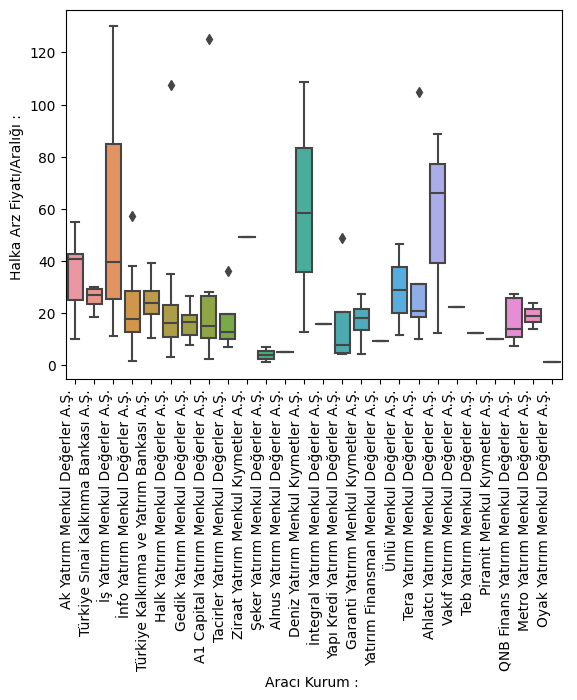

In [76]:
ax = sns.boxplot(x = info_df['Aracı Kurum : '], y =info_df['Halka Arz Fiyatı/Aralığı : ']);
ax.set_xticklabels(ax.get_xticklabels(),rotation=90);

In [77]:
Stocks_copy['EKSUN']['Halka_arz_result']['Yurtiçi Bireysel_Kisi']

0    1.209.314
Name: Yurtiçi Bireysel_Kisi, dtype: object

In [32]:
Stocks_copy['BIGCH']['Halka_arz_result']['Yurt İçi Bireysel_Kisi'].apply(value_fix_dot)

0    1800797.0
Name: Yurt İçi Bireysel_Kisi, dtype: float64

In [29]:
tesd_df = Stocks_copy['ADGYO']['Halka_arz_result']

In [30]:
tesd_df

,Yurt İçi Gerçek Kişi_Kisi,Yurt İçi Gerçek Kişi_Lot,Yurt İçi Kurumsal_Kisi,Yurt İçi Kurumsal_Lot,Yurt Dışı Gerçek Kişi_Kisi,Yurt Dışı Gerçek Kişi_Lot
0,2531660.0,73.566.342,396,12.382,4.248,121.276


In [48]:
with open('stocks.p', 'rb') as handle:
    Stocks_copy = pickle.load(handle)

In [21]:
test_cols = tesd_df.columns
test_cols

Index(['Yurt İçi Gerçek Kişi_Kisi', 'Yurt İçi Gerçek Kişi_Lot',
       'Yurt İçi Kurumsal_Kisi', 'Yurt İçi Kurumsal_Lot',
       'Yurt Dışı Gerçek Kişi_Kisi', 'Yurt Dışı Gerçek Kişi_Lot'],
      dtype='object')

In [20]:
'Yurt İçi Gerçek Kişi_Kisi' in test_cols

True

In [24]:
if ('Yurt Dışı Bireysel_Kisi' in test_cols) and ('Yurt İçi Gerçek Kişi_Kisi' in test_cols):
    print('y')
else:
    print('n')

n


In [28]:
halka_arz_result_df = pd.DataFrame()
for symbol in Stocks_copy:
    print(symbol)
    cols = Stocks_copy[symbol]['Halka_arz_result'].columns
    if ('Yurt İçi Bireysel_Kisi' in cols) and ('Yurt İçi Gerçek Kişi_Kisi' in cols):
        Stocks_copy[symbol]['Halka_arz_result']['Yurt İçi Bireysel_Kisi'] = Stocks_copy[symbol]['Halka_arz_result']['Yurt İçi Bireysel_Kisi'].apply(value_fix_dot)
        Stocks_copy[symbol]['Halka_arz_result']['Yurt İçi Gerçek Kişi_Kisi'] = Stocks_copy[symbol]['Halka_arz_result']['Yurt İçi Gerçek Kişi_Kisi'].apply(value_fix_dot)
    elif ('Yurt İçi Bireysel_Kisi' in cols):
        Stocks_copy[symbol]['Halka_arz_result']['Yurt İçi Bireysel_Kisi'] = Stocks_copy[symbol]['Halka_arz_result']['Yurt İçi Bireysel_Kisi'].apply(value_fix_dot)
    elif ('Yurt İçi Gerçek Kişi_Kisi' in cols):
        Stocks_copy[symbol]['Halka_arz_result']['Yurt İçi Gerçek Kişi_Kisi'] = Stocks_copy[symbol]['Halka_arz_result']['Yurt İçi Gerçek Kişi_Kisi'].apply(value_fix_dot)


AVPGY
MEGMT
KBORU
SURGY
CATES
SKYMD
BEGYO
AGROT
EKOS
BINHO
MARBL
TABGD
VRGYO
MHRGY
BORLS
DOFER
MEKAG
DMRGD
ADGYO
HATSN
REEDR
GIPTA
TARKM
EBEBK
KZGYO
BYDNR
ENERY
TATEN
OFSYM
IZENR
ASGYO
KLSER
FZLGY
ATAKP
FORTE
A1CAP
PASEU
KTLEV
BIENY
KAYSE
BIGCH
CWENE
GRTRK
EUPWR
CVKMD
KOPOL
EKSUN
AKFYE
GOKNR
BVSAN
MACKO
ASTOR
TNZTP
SOKE
SDTTR
ONCSM
EYGYO
TERA
AHGAZ
BRKVY
PLTUR
OZSUB
SNICA
ALFAS
AZTEK
HKTM
BARMA
OBASE
KRPLS
KLRHO
RUBNS
KCAER
PRDGS
MAKIM
EUREN
SEGYO
SUNTK
YYLGD
BMSTL
IMASM
KMPUR
CONSE
SUWEN
LIDER
SMRTG
ENSRI
GRSEL
GZNMI
KLSYN
HTTBT
INVES
DAPGM
HUNER
PNLSN
ERCB
PSGYO
RNPOL
PCILT
GMTAS
KONKA
MOBTL
MIATK
ISSEN
ELITE
ARASE
ULUFA
IHAAS
ANGEN
HEDEF
GLCVY
MAGEN
KIMMR
TEZOL
YEOTK
ORCAY
EGEPO
BRLSM
GESAN
KZBGY
GENIL
MANAS
KARYE
ESCAR
VBTYZ
KTSKR
EDATA
MEDTR
SELVA
BASGZ
OYYAT
BMSCH
UNLU
BOBET
ATATP
MERCN
KLKIM
PENTA
ZRGYO
CANTE
AYDEM
BIOEN
GWIND
TUREX
QUAGR
MTRKS
NTGAZ
TRILC
ISKPL


In [41]:
halka_arz_result_df = pd.DataFrame()
for symbol in Stocks_copy:
    print(symbol)
    Stocks_copy[symbol]['Halka_arz_result']['Yurt İçi Bireysel_Kisi'] = Stocks_copy[symbol]['Halka_arz_result']['Yurt İçi Bireysel_Kisi'].apply(value_fix_dot)
    halka_arz_result_df = pd.concat([halka_arz_result_df, Stocks_copy[symbol]['Halka_arz_result']], axis=0, join='outer')
halka_arz_result_df.head(50)

AVPGY
MEGMT
KBORU
SURGY
CATES
SKYMD
BEGYO
AGROT
EKOS
BINHO
MARBL
TABGD
VRGYO
MHRGY
BORLS
DOFER
MEKAG
DMRGD
ADGYO


KeyError: 'Yurt İçi Bireysel_Kisi'

In [42]:
Stocks_copy['AVPGY']['Halka_arz_result'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Yurt İçi Bireysel_Kisi  1 non-null      object
 1   Yurt İçi Bireysel_Lot   1 non-null      object
 2   Grup Çalışanları_Kisi   1 non-null      object
 3   Grup Çalışanları_Lot    1 non-null      object
 4   Yurt İçi Kurumsal_Kisi  1 non-null      object
 5   Yurt İçi Kurumsal_Lot   1 non-null      object
dtypes: object(6)
memory usage: 176.0+ bytes


In [114]:
with open('stocks.p', 'rb') as handle:
    Stocks_copy = pickle.load(handle)

In [52]:
cols = Stocks_copy['AVPGY']['Halka_arz_result'].columns
for col in cols:
    print(col)
    Stocks_copy['AVPGY']['Halka_arz_result'][col] = Stocks_copy['AVPGY']['Halka_arz_result'][col].apply(value_fix_dot)

Yurt İçi Bireysel_Kisi
Yurt İçi Bireysel_Lot
Grup Çalışanları_Kisi
Grup Çalışanları_Lot
Yurt İçi Kurumsal_Kisi
Yurt İçi Kurumsal_Lot


In [81]:
get_hyped_days(stocks["ENTRA"]["Hist_data"])

0

In [84]:
test = stocks["ENTRA"]["Hist_data"]
test

,Open,High,Low,Close,Volume
Date,,,,,
2024-04-04,11.00,11.00,11.00,11.00,422628
2024-04-05,12.10,12.10,12.10,12.10,620120
2024-04-08,13.31,13.31,13.31,13.31,1544032
2024-04-09,14.64,14.64,14.64,14.64,1538546
2024-04-15,16.10,16.10,16.10,16.10,21578137


In [87]:
test["next_day"] = test["Open"].shift(-1, axis = 0)
test

,Open,High,Low,Close,Volume,next_day
Date,,,,,,
2024-04-04,11.00,11.00,11.00,11.00,422628,12.10
2024-04-05,12.10,12.10,12.10,12.10,620120,13.31
2024-04-08,13.31,13.31,13.31,13.31,1544032,14.64
2024-04-09,14.64,14.64,14.64,14.64,1538546,16.10
2024-04-15,16.10,16.10,16.10,16.10,21578137,NaN


In [92]:
check = [test["Close"]>= test["next_day"]][0]
check[0]

False

In [98]:
test["next_day"].isna()

Date
2024-04-04    False
2024-04-05    False
2024-04-08    False
2024-04-09    False
2024-04-15     True
Name: next_day, dtype: bool

In [115]:
get_hyped_days(test)

KeyError: True

In [99]:
np.NAN

nan

In [93]:
test.shape[0]

5

In [91]:
day = 0
while not check[day]:
    

False

In [106]:
test = Stocks_copy["MOGAN"]["Hist_data"]
test

,Open,High,Low,Close,Volume
Date,,,,,
2024-03-05,11.330000,11.330000,11.330000,11.330000,0
2024-03-06,11.330000,11.330000,11.330000,11.330000,0
2024-03-07,12.460000,12.460000,12.460000,12.460000,339828
2024-03-08,13.700000,13.700000,13.700000,13.700000,1642872
2024-03-11,15.070000,15.070000,15.070000,15.070000,2550222
2024-03-12,16.570000,16.570000,16.570000,16.570000,36654520
2024-03-13,16.000000,18.219999,15.190000,18.219999,471117000
2024-03-14,18.510000,20.040001,18.240000,20.040001,101004600
2024-03-15,21.040001,22.040001,20.879999,22.040001,39319270


In [124]:
test = test[test["Volume"] != 0]
test

,Open,High,Low,Close,Volume,Next_day_open
Date,,,,,,
2024-03-07,12.460000,12.460000,12.460000,12.460000,339828,13.700000
2024-03-08,13.700000,13.700000,13.700000,13.700000,1642872,15.070000
2024-03-11,15.070000,15.070000,15.070000,15.070000,2550222,16.570000
2024-03-12,16.570000,16.570000,16.570000,16.570000,36654520,16.000000
2024-03-13,16.000000,18.219999,15.190000,18.219999,471117000,18.510000
2024-03-14,18.510000,20.040001,18.240000,20.040001,101004600,21.040001
2024-03-15,21.040001,22.040001,20.879999,22.040001,39319270,22.059999
2024-03-18,22.059999,24.000000,19.980000,20.440001,252164800,20.240000
2024-03-19,20.240000,21.000000,19.000000,19.590000,169973800,19.559999


In [123]:
test

,Open,High,Low,Close,Volume,Next_day_open
Date,,,,,,
2024-03-07,12.460000,12.460000,12.460000,12.460000,339828,13.700000
2024-03-08,13.700000,13.700000,13.700000,13.700000,1642872,15.070000
2024-03-11,15.070000,15.070000,15.070000,15.070000,2550222,16.570000
2024-03-12,16.570000,16.570000,16.570000,16.570000,36654520,16.000000
2024-03-13,16.000000,18.219999,15.190000,18.219999,471117000,18.510000
2024-03-14,18.510000,20.040001,18.240000,20.040001,101004600,21.040001
2024-03-15,21.040001,22.040001,20.879999,22.040001,39319270,22.059999
2024-03-18,22.059999,24.000000,19.980000,20.440001,252164800,20.240000
2024-03-19,20.240000,21.000000,19.000000,19.590000,169973800,19.559999


In [120]:
test['Next_day_open'] = test['Open'].shift(-1, axis = 0)


/var/folders/nw/gghxs9bd0xx7_4l1shb5xtmc0000gn/T/ipykernel_46575/2039095983.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Next_day_open'] = test['Open'].shift(-1, axis = 0)


In [121]:
test

,Open,High,Low,Close,Volume,Next_day_open
Date,,,,,,
2024-03-07,12.460000,12.460000,12.460000,12.460000,339828,13.700000
2024-03-08,13.700000,13.700000,13.700000,13.700000,1642872,15.070000
2024-03-11,15.070000,15.070000,15.070000,15.070000,2550222,16.570000
2024-03-12,16.570000,16.570000,16.570000,16.570000,36654520,16.000000
2024-03-13,16.000000,18.219999,15.190000,18.219999,471117000,18.510000
2024-03-14,18.510000,20.040001,18.240000,20.040001,101004600,21.040001
2024-03-15,21.040001,22.040001,20.879999,22.040001,39319270,22.059999
2024-03-18,22.059999,24.000000,19.980000,20.440001,252164800,20.240000
2024-03-19,20.240000,21.000000,19.000000,19.590000,169973800,19.559999


In [126]:
halka_arz_result_df = pd.DataFrame()
for symbol in Stocks_copy:
    for col in Stocks_copy[symbol]['Halka_arz_result'].columns:
        Stocks_copy[symbol]['Halka_arz_result'][col] = Stocks_copy[symbol]['Halka_arz_result'][col].apply(value_fix_dot)
    Stocks_copy[symbol]['Halka_arz_result']['Symbol'] = str(symbol)
    if Stocks_copy[symbol]['Hist_data'].shape[0] == 0:
        continue
    Stocks_copy[symbol]['Halka_arz_result']['Hype_Days'] = get_hyped_days(Stocks_copy[symbol]['Hist_data'])
    halka_arz_result_df = pd.concat([halka_arz_result_df, Stocks_copy[symbol]['Halka_arz_result']], axis=0, join='outer')
halka_arz_result_df.head(50)

,Yurt İçi Bireysel_Kisi,Yurt İçi Bireysel_Lot,Yurt İçi Kurumsal_Kisi,Yurt İçi Kurumsal_Lot,Symbol,Hype_Days,Yurt Dışı Kurumsal_Kisi,Yurt Dışı Kurumsal_Lot,Yurt Dışı Bireysel_Kisi,Yurt Dışı Bireysel_Lot,...,Yurtiçi Kurumsal_Kisi,Yurtiçi Kurumsal_Lot,Yurtdışı Bireysel_Kisi,Yurtdışı Bireysel_Lot,Yurtdışı Kurumsal_Kisi,Yurtdışı Kurumsal_Lot,Yüksek Başvurulu_Kisi,Yüksek Başvurulu_Lot,Yüksek Başvurulu Bireysel_Kisi,Yüksek Başvurulu Bireysel_Lot
0,3586255.0,277174288.0,276.0,92391429.0,ENTRA,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,3198260.0,26520000.0,182.0,15470000.0,ODINE,10.0,4.0,2210000.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,3502171.0,210108000.0,212.0,52527000.0,MOGAN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,2185014.0,19959421.0,49.0,448.0,ARTMS,9.0,NaN,NaN,4435.0,40131.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,3388122.0,47204809.0,268.0,43351355.0,OBAMS,6.0,13.0,4816818.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,2870401.0,32000000.0,215.0,8000000.0,ALVES,9.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,3243525.0,109151000.0,298.0,46779000.0,LMKDC,9.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,2598451.0,41361289.0,198.0,21000000.0,BORSK,6.0,8.0,7000000.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,2390045.0,18900000.0,132.0,8100000.0,PATEK,15.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,3653597.0,78630631.0,119.0,20000000.0,AVPGY,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [127]:
halka_arz_result_df.head(10)

,Yurt İçi Bireysel_Kisi,Yurt İçi Bireysel_Lot,Yurt İçi Kurumsal_Kisi,Yurt İçi Kurumsal_Lot,Symbol,Hype_Days,Yurt Dışı Kurumsal_Kisi,Yurt Dışı Kurumsal_Lot,Yurt Dışı Bireysel_Kisi,Yurt Dışı Bireysel_Lot,...,Yurtiçi Kurumsal_Kisi,Yurtiçi Kurumsal_Lot,Yurtdışı Bireysel_Kisi,Yurtdışı Bireysel_Lot,Yurtdışı Kurumsal_Kisi,Yurtdışı Kurumsal_Lot,Yüksek Başvurulu_Kisi,Yüksek Başvurulu_Lot,Yüksek Başvurulu Bireysel_Kisi,Yüksek Başvurulu Bireysel_Lot
0,3586255.0,277174288.0,276.0,92391429.0,ENTRA,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,3198260.0,26520000.0,182.0,15470000.0,ODINE,10.0,4.0,2210000.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,3502171.0,210108000.0,212.0,52527000.0,MOGAN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,2185014.0,19959421.0,49.0,448.0,ARTMS,9.0,NaN,NaN,4435.0,40131.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,3388122.0,47204809.0,268.0,43351355.0,OBAMS,6.0,13.0,4816818.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,2870401.0,32000000.0,215.0,8000000.0,ALVES,9.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,3243525.0,109151000.0,298.0,46779000.0,LMKDC,9.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,2598451.0,41361289.0,198.0,21000000.0,BORSK,6.0,8.0,7000000.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,2390045.0,18900000.0,132.0,8100000.0,PATEK,15.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,3653597.0,78630631.0,119.0,20000000.0,AVPGY,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [145]:
halka_arz_result_df.fillna(0, inplace=True)
halka_arz_result_df.reset_index(inplace=True, drop=True)

In [146]:
halka_arz_result_df

,level_0,index,Yurt İçi Bireysel_Kisi,Yurt İçi Bireysel_Lot,Yurt İçi Kurumsal_Kisi,Yurt İçi Kurumsal_Lot,Symbol,Hype_Days,Yurt Dışı Kurumsal_Kisi,Yurt Dışı Kurumsal_Lot,...,Yurtiçi Kurumsal_Kisi,Yurtiçi Kurumsal_Lot,Yurtdışı Bireysel_Kisi,Yurtdışı Bireysel_Lot,Yurtdışı Kurumsal_Kisi,Yurtdışı Kurumsal_Lot,Yüksek Başvurulu_Kisi,Yüksek Başvurulu_Lot,Yüksek Başvurulu Bireysel_Kisi,Yüksek Başvurulu Bireysel_Lot
0,0,0,3586255.0,277174288.0,276.0,92391429.0,ENTRA,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,3198260.0,26520000.0,182.0,15470000.0,ODINE,10.0,4.0,2210000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0,3502171.0,210108000.0,212.0,52527000.0,MOGAN,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0,2185014.0,19959421.0,49.0,448.0,ARTMS,9.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0,3388122.0,47204809.0,268.0,43351355.0,OBAMS,6.0,13.0,4816818.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,98,0,0.0,0.0,0.0,0.0,HTTBT,1.0,0.0,0.0,...,87.0,12317307.0,0.0,0.0,8.0,8798077.0,2461.0,7038462.0,0.0,0.0
99,99,0,0.0,0.0,0.0,0.0,INVES,1.0,0.0,0.0,...,48.0,3089363.0,139.0,19440.0,1.0,1000.0,0.0,0.0,0.0,0.0
100,100,0,0.0,0.0,0.0,0.0,DAPGM,1.0,0.0,0.0,...,46.0,4204194.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
101,101,0,0.0,0.0,0.0,0.0,HUNER,0.0,0.0,0.0,...,49.0,26063.0,319.0,172130.0,0.0,0.0,0.0,0.0,0.0,0.0


In [134]:
print(halka_arz_result_df.columns)

Index(['index', 'Yurt İçi Bireysel_Kisi', 'Yurt İçi Bireysel_Lot',
       'Yurt İçi Kurumsal_Kisi', 'Yurt İçi Kurumsal_Lot', 'Symbol',
       'Hype_Days', 'Yurt Dışı Kurumsal_Kisi', 'Yurt Dışı Kurumsal_Lot',
       'Yurt Dışı Bireysel_Kisi', 'Yurt Dışı Bireysel_Lot',
       'Şirket Çalışanları_Kisi', 'Şirket Çalışanları_Lot',
       'Şirket Çalışanları & Çiftçi Grubu_Kisi',
       'Şirket Çalışanları & Çiftçi Grubu_Lot', 'Grup Çalışanları_Kisi',
       'Grup Çalışanları_Lot', 'Yurt İçi Gerçek Kişi_Kisi',
       'Yurt İçi Gerçek Kişi_Lot', 'Yurt Dışı Gerçek Kişi_Kisi',
       'Yurt Dışı Gerçek Kişi_Lot', 'Kale Grubu Çalışanları_Kisi',
       'Kale Grubu Çalışanları_Lot',
       'Şirket Çalışanları / Çiftçi Yatırımcı_Kisi',
       'Şirket Çalışanları / Çiftçi Yatırımcı_Lot', 'Yurtiçi Bireysel_Kisi',
       'Yurtiçi Bireysel_Lot', 'Yurtiçi Kurumsal_Kisi', 'Yurtiçi Kurumsal_Lot',
       'Yurtdışı Bireysel_Kisi', 'Yurtdışı Bireysel_Lot',
       'Yurtdışı Kurumsal_Kisi', 'Yurtdışı Kurumsal_L

In [147]:
halka_arz_result_df["Yurt İçi Bireysel_Kisi"] +halka_arz_result_df['Yurt İçi Gerçek Kişi_Kisi']+ halka_arz_result_df['Yurtiçi Bireysel_Kisi']

0      3586255.0
1      3198260.0
2      3502171.0
3      2185014.0
4      3388122.0
         ...    
98       45712.0
99      122015.0
100      45390.0
101     242732.0
102      42025.0
Length: 103, dtype: float64

In [148]:
df = pd.DataFrame()
df['Symbol'] = halka_arz_result_df['Symbol']
df['HypeDays'] = halka_arz_result_df['Hype_Days']
df['Yurtici_Kisi'] = halka_arz_result_df['Yurt İçi Bireysel_Kisi'] + halka_arz_result_df['Yurt İçi Gerçek Kişi_Kisi'] + halka_arz_result_df['Yurtiçi Bireysel_Kisi']
df['Yurtici_Lot'] = halka_arz_result_df['Yurt İçi Bireysel_Lot'] + halka_arz_result_df['Yurt İçi Gerçek Kişi_Lot'] + halka_arz_result_df['Yurtiçi Bireysel_Lot']
df['Yurtdisi_Kisi'] = halka_arz_result_df['Yurt Dışı Bireysel_Kisi'] + halka_arz_result_df['Yurt Dışı Gerçek Kişi_Kisi'] + halka_arz_result_df['Yurtdışı Bireysel_Kisi']
df['Yurtdisi_Lot'] = halka_arz_result_df['Yurt Dışı Bireysel_Lot'] + halka_arz_result_df['Yurt Dışı Gerçek Kişi_Lot'] + halka_arz_result_df['Yurtdışı Bireysel_Lot']
df['Yurtici_Kurumsal'] = halka_arz_result_df['Yurt İçi Kurumsal_Kisi']  + halka_arz_result_df['Yurtiçi Kurumsal_Kisi']
df['Yurtici_Kurumsal_Lot'] = halka_arz_result_df['Yurt İçi Kurumsal_Lot']  + halka_arz_result_df['Yurtiçi Kurumsal_Lot']
df['Yurtdisi_Kurumsal'] = halka_arz_result_df['Yurt Dışı Kurumsal_Kisi']  + halka_arz_result_df['Yurtdışı Kurumsal_Kisi']
df['Yurtdisi_Kurumsal_Lot'] = halka_arz_result_df['Yurt Dışı Kurumsal_Lot']  + halka_arz_result_df['Yurtdışı Kurumsal_Lot']
df['Sirket_Calisanlari_Kisi'] = halka_arz_result_df['Şirket Çalışanları_Kisi'] + halka_arz_result_df['Grup Çalışanları_Kisi'] + halka_arz_result_df['Şirket Çalışanları / Çiftçi Yatırımcı_Kisi'] + halka_arz_result_df['Kale Grubu Çalışanları_Kisi'] 
df['Sirket_Calisanlari_Lot'] = halka_arz_result_df['Şirket Çalışanları_Lot'] + halka_arz_result_df['Grup Çalışanları_Lot'] + halka_arz_result_df['Şirket Çalışanları / Çiftçi Yatırımcı_Lot'] + halka_arz_result_df['Kale Grubu Çalışanları_Lot'] 
df['Yuksek Başvurulu_Kisi'] = halka_arz_result_df['Yüksek Başvurulu_Kisi']
df['Yuksek Başvurulu_Lot'] = halka_arz_result_df['Yüksek Başvurulu_Lot']
df['Yuksek Başvurulu Bireysel_Kisi'] = halka_arz_result_df['Yüksek Başvurulu Bireysel_Kisi']
df['Yuksek Başvurulu Bireysel_Lot'] = halka_arz_result_df['Yüksek Başvurulu Bireysel_Lot']

df

,Symbol,HypeDays,Yurtici_Kisi,Yurtici_Lot,Yurtdisi_Kisi,Yurtdisi_Lot,Yurtici_Kurumsal,Yurtici_Kurumsal_Lot,Yurtdisi_Kurumsal,Yurtdisi_Kurumsal_Lot,Sirket_Calisanlari_Kisi,Sirket_Calisanlari_Lot,Yuksek Başvurulu_Kisi,Yuksek Başvurulu_Lot,Yuksek Başvurulu Bireysel_Kisi,Yuksek Başvurulu Bireysel_Lot
0,ENTRA,0.0,3586255.0,277174288.0,0.0,0.0,276.0,92391429.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ODINE,10.0,3198260.0,26520000.0,0.0,0.0,182.0,15470000.0,4.0,2210000.0,0.0,0.0,0.0,0.0,0.0,0.0
2,MOGAN,3.0,3502171.0,210108000.0,0.0,0.0,212.0,52527000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ARTMS,9.0,2185014.0,19959421.0,4435.0,40131.0,49.0,448.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,OBAMS,6.0,3388122.0,47204809.0,0.0,0.0,268.0,43351355.0,13.0,4816818.0,421.0,963363.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,HTTBT,1.0,45712.0,7038462.0,0.0,0.0,87.0,12317307.0,8.0,8798077.0,0.0,0.0,2461.0,7038462.0,0.0,0.0
99,INVES,1.0,122015.0,34390197.0,139.0,19440.0,48.0,3089363.0,1.0,1000.0,0.0,0.0,0.0,0.0,0.0,0.0
100,DAPGM,1.0,45390.0,25815806.0,0.0,0.0,46.0,4204194.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
101,HUNER,0.0,242732.0,129801807.0,319.0,172130.0,49.0,26063.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [153]:
df['Total_Lot'] = df['Yurtici_Lot'] + df['Yurtdisi_Lot'] + df['Yurtici_Kurumsal_Lot'] + df['Yurtdisi_Kurumsal_Lot'] + df['Sirket_Calisanlari_Lot'] + df['Yuksek Başvurulu_Lot'] + df['Yuksek Başvurulu Bireysel_Lot']
df['Total_Kisi'] = df['Yurtici_Kisi'] + df['Yurtdisi_Kisi'] + df['Yurtici_Kurumsal'] + df['Yurtdisi_Kurumsal'] + df['Sirket_Calisanlari_Kisi'] + df['Yuksek Başvurulu_Kisi'] + df['Yuksek Başvurulu Bireysel_Kisi']
df['Kurumsal_Oran'] = (df['Yurtici_Kurumsal_Lot'] + df['Yurtdisi_Kurumsal_Lot'])/df['Total_Lot'] * 100
df['Bireysel_Oran'] = (df['Yurtici_Lot'] + df['Yurtdisi_Lot'])/df['Total_Lot'] * 100
df['Bireysel_Kisi_Oran'] = (df['Yurtici_Kisi'] + df['Yurtdisi_Kisi'])/df['Total_Kisi'] * 100
df['Kurumsal_Kisi_Oran'] = (df['Yurtici_Kurumsal'] + df['Yurtdisi_Kurumsal'])/df['Total_Kisi'] * 100
df

,Symbol,HypeDays,Yurtici_Kisi,Yurtici_Lot,Yurtdisi_Kisi,Yurtdisi_Lot,Yurtici_Kurumsal,Yurtici_Kurumsal_Lot,Yurtdisi_Kurumsal,Yurtdisi_Kurumsal_Lot,...,Yuksek Başvurulu_Kisi,Yuksek Başvurulu_Lot,Yuksek Başvurulu Bireysel_Kisi,Yuksek Başvurulu Bireysel_Lot,Total_Lot,Total_Kisi,Kurumsal_Oran,Bireysel_Oran,Bireysel_Kisi_Oran,Kurumsal_Kisi_Oran
0,ENTRA,0.0,3586255.0,277174288.0,0.0,0.0,276.0,92391429.0,0.0,0.0,...,0.0,0.0,0.0,0.0,369565717.0,3586531.0,25.000000,75.000000,99.992305,0.007695
1,ODINE,10.0,3198260.0,26520000.0,0.0,0.0,182.0,15470000.0,4.0,2210000.0,...,0.0,0.0,0.0,0.0,44200000.0,3198446.0,40.000000,60.000000,99.994185,0.005815
2,MOGAN,3.0,3502171.0,210108000.0,0.0,0.0,212.0,52527000.0,0.0,0.0,...,0.0,0.0,0.0,0.0,262635000.0,3502383.0,20.000000,80.000000,99.993947,0.006053
3,ARTMS,9.0,2185014.0,19959421.0,4435.0,40131.0,49.0,448.0,0.0,0.0,...,0.0,0.0,0.0,0.0,20000000.0,2189498.0,0.002240,99.997760,99.997762,0.002238
4,OBAMS,6.0,3388122.0,47204809.0,0.0,0.0,268.0,43351355.0,13.0,4816818.0,...,0.0,0.0,0.0,0.0,96336345.0,3388824.0,50.000001,49.000000,99.979285,0.008292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,HTTBT,1.0,45712.0,7038462.0,0.0,0.0,87.0,12317307.0,8.0,8798077.0,...,2461.0,7038462.0,0.0,0.0,35192308.0,48268.0,59.999998,20.000001,94.704566,0.196818
99,INVES,1.0,122015.0,34390197.0,139.0,19440.0,48.0,3089363.0,1.0,1000.0,...,0.0,0.0,0.0,0.0,37500000.0,122203.0,8.240968,91.759032,99.959903,0.040097
100,DAPGM,1.0,45390.0,25815806.0,0.0,0.0,46.0,4204194.0,0.0,0.0,...,0.0,0.0,0.0,0.0,30020000.0,45436.0,14.004644,85.995356,99.898759,0.101241
101,HUNER,0.0,242732.0,129801807.0,319.0,172130.0,49.0,26063.0,0.0,0.0,...,0.0,0.0,0.0,0.0,130000000.0,243100.0,0.020048,99.979952,99.979844,0.020156


In [154]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Symbol                          103 non-null    object 
 1   HypeDays                        103 non-null    float64
 2   Yurtici_Kisi                    103 non-null    float64
 3   Yurtici_Lot                     103 non-null    float64
 4   Yurtdisi_Kisi                   103 non-null    float64
 5   Yurtdisi_Lot                    103 non-null    float64
 6   Yurtici_Kurumsal                103 non-null    float64
 7   Yurtici_Kurumsal_Lot            103 non-null    float64
 8   Yurtdisi_Kurumsal               103 non-null    float64
 9   Yurtdisi_Kurumsal_Lot           103 non-null    float64
 10  Sirket_Calisanlari_Kisi         103 non-null    float64
 11  Sirket_Calisanlari_Lot          103 non-null    float64
 12  Yuksek Başvurulu_Kisi           103 

In [155]:
import seaborn as sns
import matplotlib.pyplot as plt


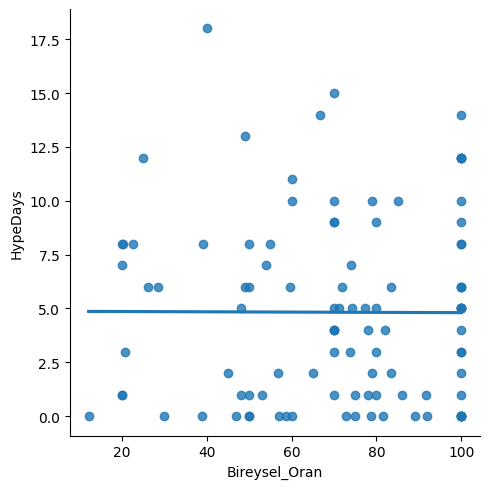

In [156]:
sns.lmplot(x='Bireysel_Oran', y='HypeDays', data=df, ci=None)
plt.show()

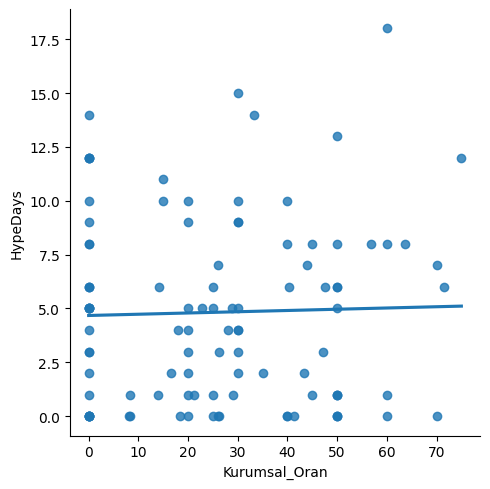

In [157]:
sns.lmplot(x='Kurumsal_Oran', y='HypeDays', data=df, ci=None)
plt.show()

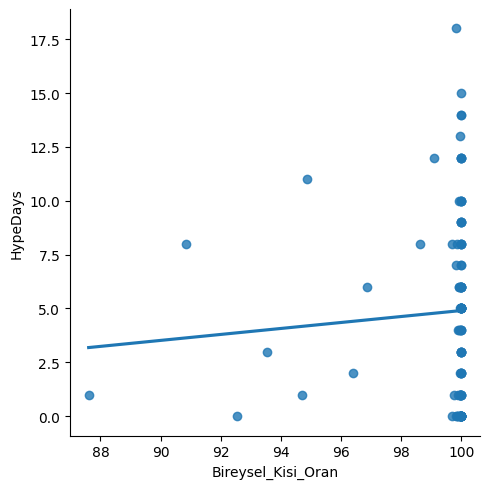

In [158]:
sns.lmplot(x='Bireysel_Kisi_Oran', y='HypeDays', data=df, ci=None)
plt.show()

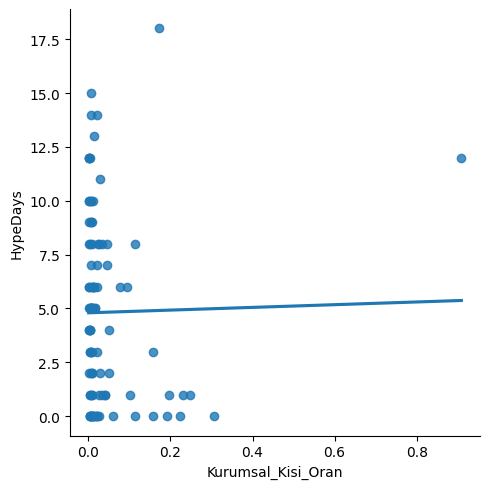

In [159]:
sns.lmplot(x='Kurumsal_Kisi_Oran', y='HypeDays', data=df, ci=None)
plt.show()

In [116]:
info_df.columns

Index(['Halka Arz Fiyatı/Aralığı : ', 'Dağıtım Yöntemi : ', 'Pay : ',
       'Aracı Kurum : ', 'Bist Kodu : ', 'Pazar : '],
      dtype='object')

In [160]:
info_df.set_index('Bist Kodu : ', inplace=True)

In [161]:
info_df.loc['AVPGY']['Halka Arz Fiyatı/Aralığı : ']

55.08

In [162]:
df_ = df.set_index('Symbol')
df_

,HypeDays,Yurtici_Kisi,Yurtici_Lot,Yurtdisi_Kisi,Yurtdisi_Lot,Yurtici_Kurumsal,Yurtici_Kurumsal_Lot,Yurtdisi_Kurumsal,Yurtdisi_Kurumsal_Lot,Sirket_Calisanlari_Kisi,...,Yuksek Başvurulu_Kisi,Yuksek Başvurulu_Lot,Yuksek Başvurulu Bireysel_Kisi,Yuksek Başvurulu Bireysel_Lot,Total_Lot,Total_Kisi,Kurumsal_Oran,Bireysel_Oran,Bireysel_Kisi_Oran,Kurumsal_Kisi_Oran
Symbol,,,,,,,,,,,,,,,,,,,,,
ENTRA,0.0,3586255.0,277174288.0,0.0,0.0,276.0,92391429.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,369565717.0,3586531.0,25.000000,75.000000,99.992305,0.007695
ODINE,10.0,3198260.0,26520000.0,0.0,0.0,182.0,15470000.0,4.0,2210000.0,0.0,...,0.0,0.0,0.0,0.0,44200000.0,3198446.0,40.000000,60.000000,99.994185,0.005815
MOGAN,3.0,3502171.0,210108000.0,0.0,0.0,212.0,52527000.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,262635000.0,3502383.0,20.000000,80.000000,99.993947,0.006053
ARTMS,9.0,2185014.0,19959421.0,4435.0,40131.0,49.0,448.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,20000000.0,2189498.0,0.002240,99.997760,99.997762,0.002238
OBAMS,6.0,3388122.0,47204809.0,0.0,0.0,268.0,43351355.0,13.0,4816818.0,421.0,...,0.0,0.0,0.0,0.0,96336345.0,3388824.0,50.000001,49.000000,99.979285,0.008292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HTTBT,1.0,45712.0,7038462.0,0.0,0.0,87.0,12317307.0,8.0,8798077.0,0.0,...,2461.0,7038462.0,0.0,0.0,35192308.0,48268.0,59.999998,20.000001,94.704566,0.196818
INVES,1.0,122015.0,34390197.0,139.0,19440.0,48.0,3089363.0,1.0,1000.0,0.0,...,0.0,0.0,0.0,0.0,37500000.0,122203.0,8.240968,91.759032,99.959903,0.040097
DAPGM,1.0,45390.0,25815806.0,0.0,0.0,46.0,4204194.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,30020000.0,45436.0,14.004644,85.995356,99.898759,0.101241


In [163]:
idx = df_.index
df_['Halka Arz Fiyat'] = info_df.loc[idx]['Halka Arz Fiyatı/Aralığı : ']

In [164]:
df_

,HypeDays,Yurtici_Kisi,Yurtici_Lot,Yurtdisi_Kisi,Yurtdisi_Lot,Yurtici_Kurumsal,Yurtici_Kurumsal_Lot,Yurtdisi_Kurumsal,Yurtdisi_Kurumsal_Lot,Sirket_Calisanlari_Kisi,...,Yuksek Başvurulu_Lot,Yuksek Başvurulu Bireysel_Kisi,Yuksek Başvurulu Bireysel_Lot,Total_Lot,Total_Kisi,Kurumsal_Oran,Bireysel_Oran,Bireysel_Kisi_Oran,Kurumsal_Kisi_Oran,Halka Arz Fiyat
Symbol,,,,,,,,,,,,,,,,,,,,,
ENTRA,0.0,3586255.0,277174288.0,0.0,0.0,276.0,92391429.0,0.0,0.0,0.0,...,0.0,0.0,0.0,369565717.0,3586531.0,25.000000,75.000000,99.992305,0.007695,10.00
ODINE,10.0,3198260.0,26520000.0,0.0,0.0,182.0,15470000.0,4.0,2210000.0,0.0,...,0.0,0.0,0.0,44200000.0,3198446.0,40.000000,60.000000,99.994185,0.005815,30.00
MOGAN,3.0,3502171.0,210108000.0,0.0,0.0,212.0,52527000.0,0.0,0.0,0.0,...,0.0,0.0,0.0,262635000.0,3502383.0,20.000000,80.000000,99.993947,0.006053,11.33
ARTMS,9.0,2185014.0,19959421.0,4435.0,40131.0,49.0,448.0,0.0,0.0,0.0,...,0.0,0.0,0.0,20000000.0,2189498.0,0.002240,99.997760,99.997762,0.002238,25.35
OBAMS,6.0,3388122.0,47204809.0,0.0,0.0,268.0,43351355.0,13.0,4816818.0,421.0,...,0.0,0.0,0.0,96336345.0,3388824.0,50.000001,49.000000,99.979285,0.008292,39.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HTTBT,1.0,45712.0,7038462.0,0.0,0.0,87.0,12317307.0,8.0,8798077.0,0.0,...,7038462.0,0.0,0.0,35192308.0,48268.0,59.999998,20.000001,94.704566,0.196818,11.50
INVES,1.0,122015.0,34390197.0,139.0,19440.0,48.0,3089363.0,1.0,1000.0,0.0,...,0.0,0.0,0.0,37500000.0,122203.0,8.240968,91.759032,99.959903,0.040097,24.00
DAPGM,1.0,45390.0,25815806.0,0.0,0.0,46.0,4204194.0,0.0,0.0,0.0,...,0.0,0.0,0.0,30020000.0,45436.0,14.004644,85.995356,99.898759,0.101241,18.50


In [165]:
df_ = df_[df_["HypeDays"] != 0]

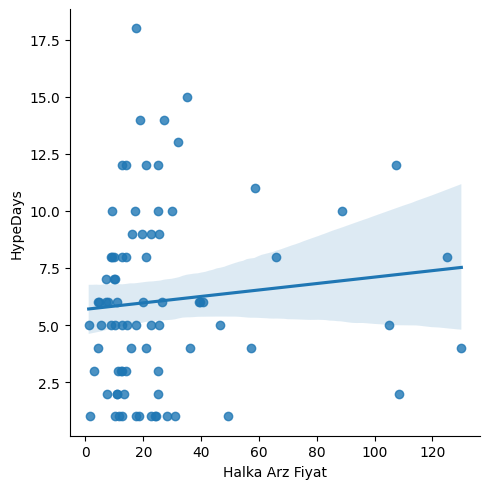

In [166]:
sns.lmplot(x='Halka Arz Fiyat', y='HypeDays', data=df_)
plt.show()